# Libraries and Data Load

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from matplotlib import pyplot as plt
import zipfile
import os
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/anime.zip"
extract_path = "content/anime"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Parameters
IMG_SIZE = 64  # desired image width and height

folder_path = os.path.join("content", "anime", "images")

image_paths = glob.glob(os.path.join(folder_path, "*"))

images = []

for image_path in image_paths:
    img = cv2.imread(image_path)
    if img is None:
        continue  # Skip images that can't be read
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    images.append(img)

# Convert list to NumPy array and normalize pixel values to [0, 1]
x_data = np.array(images, dtype='float32') / 255.0

print("x_data shape:", x_data.shape)


x_data shape: (63565, 64, 64, 3)


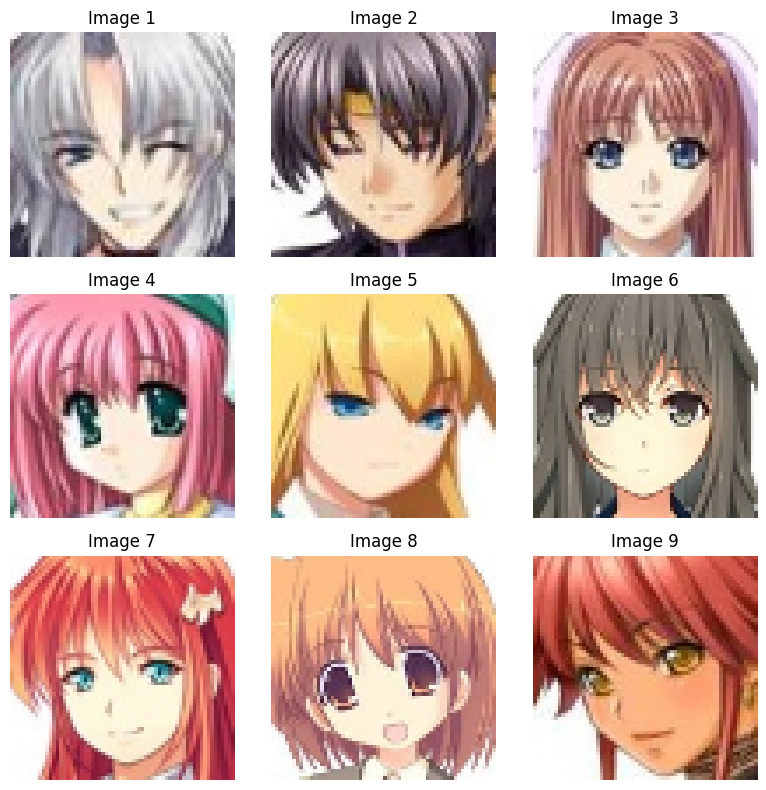

In [ ]:
num_samples = 9

plt.figure(figsize=(8, 8))

for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_data[i])
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# GAN Model

## Architecture

In [ ]:
# Size of the input noise vector
latent_dim = 100

In [ ]:
# Generator
noise = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(4 * 4 * 256, activation='relu')(noise)
x = keras.layers.Reshape((4, 4, 256))(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')(x)
fake_image = keras.layers.Activation('sigmoid')(x)

generator = keras.Model(noise, fake_image)

In [ ]:
# Discriminator
img = keras.Input(shape=(64, 64, 3))
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(64, 64, 3), padding='same')(img)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(img)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(img)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)
pred_label = keras.layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.Model(img, pred_label)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Customized training

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        # Initialize the model: the call will pass as arguments:
        # - The discriminator model
        # - The generator model
        # - The dimension of the latent space (noise)
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        # Compile the model: the call will pass as arguments:
        # - The optimizer to be used to update the discriminator
        # - The optimizer to be used to update the generator
        # - The loss function
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # For each iteration we will train using both:
        # - real data (passed from 'fit()')
        # - fake data (created in here)
        # The generator creates fake data from random noise.
        # The discriminator is fed both real data and fake data.

        batch_size = tf.shape(real_images)[0]

        # Discriminator ---------------------------------------------------

        # Create fake data from random noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_images = self.generator(noise)

        # Combine fake and real data, and create the corresponding fake:0/real:1 labels
        combo_images = tf.concat([fake_images, real_images], axis=0)
        combo_labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator:
        # - Define the path of the training model
        #   (input: combined images, output: output of the discriminator)
        # - Compute gradient on selected weights
        #   (only discriminator)
        # - Apply gradient using optimizer
        with tf.GradientTape() as tape:
            pred_labels = self.discriminator(combo_images)
            d_loss = self.loss_fn(combo_labels, pred_labels)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generator ---------------------------------------------------

        # Sample random noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images" (purposedly misleading!)
        real_labels = tf.ones((batch_size, 1))

        # Train the generator
        # - Define the path of the training model
        #   (input: random noise, output: output of the **discriminator**)
        # - Compute gradient on selected weights
        #   (only generator)
        # - Apply gradient using optimizer
        with tf.GradientTape() as tape:
            pred_labels = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(real_labels, pred_labels)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

### Callbacks

In [ ]:
class VisualizationCallback_GAN(keras.callbacks.Callback):
    def __init__(self, sample_interval=1):
        os.makedirs('images', exist_ok=True)
        super(VisualizationCallback_GAN, self).__init__()
        self.sample_interval = sample_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            # Create 5x10 instances of random noise every 5 epochs
            r, c = 5, 10
            noise = tf.random.normal(shape=(r * c, latent_dim))
            # Generate images from noise
            gen_imgs = generator.predict(noise)
            # Visualize the generated images
            fig, axs = plt.subplots(r, c, figsize=(c * 2, r * 2))
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i, j].imshow(gen_imgs[cnt])
                    axs[i, j].axis('off')
                    cnt += 1
            fig.savefig('images/%06d.png' % epoch)
            plt.close()


### Compile and Train

In [ ]:
# Initialize the model
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [ ]:
# Compile the model
gan.compile(
    d_optimizer=keras.optimizers.Adam(0.0002, 0.5),
    g_optimizer=keras.optimizers.Adam(0.0002, 0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [ ]:
# Train the model
gan.fit(x_data, epochs=50, callbacks=[VisualizationCallback_GAN()])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - d_loss: 0.4710 - g_loss: 1.6572
Epoch 2/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 17ms/step - d_loss: 0.5070 - g_loss: 1.2996
Epoch 3/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - d_loss: 0.5473 - g_loss: 1.2449
Epoch 4/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - d_loss: 0.6179 - g_loss: 1.0669
Epoch 5/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - d_loss: 0.6534 - g_loss: 0.9436
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - d_loss: 0.6526 - g_loss: 0.9361
Epoch 7/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - d_loss: 0.6567 - g_loss: 0.9263
Epoch 8/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - d_loss: 0.6520 - g_loss: 0.9271
Epoch 9/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - d_loss: 0.6548 - g_loss: 0.9184
Epoch 10/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - d_loss: 0.6526 - g_loss: 0.9173
Epoch 11/50
2/2 ━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


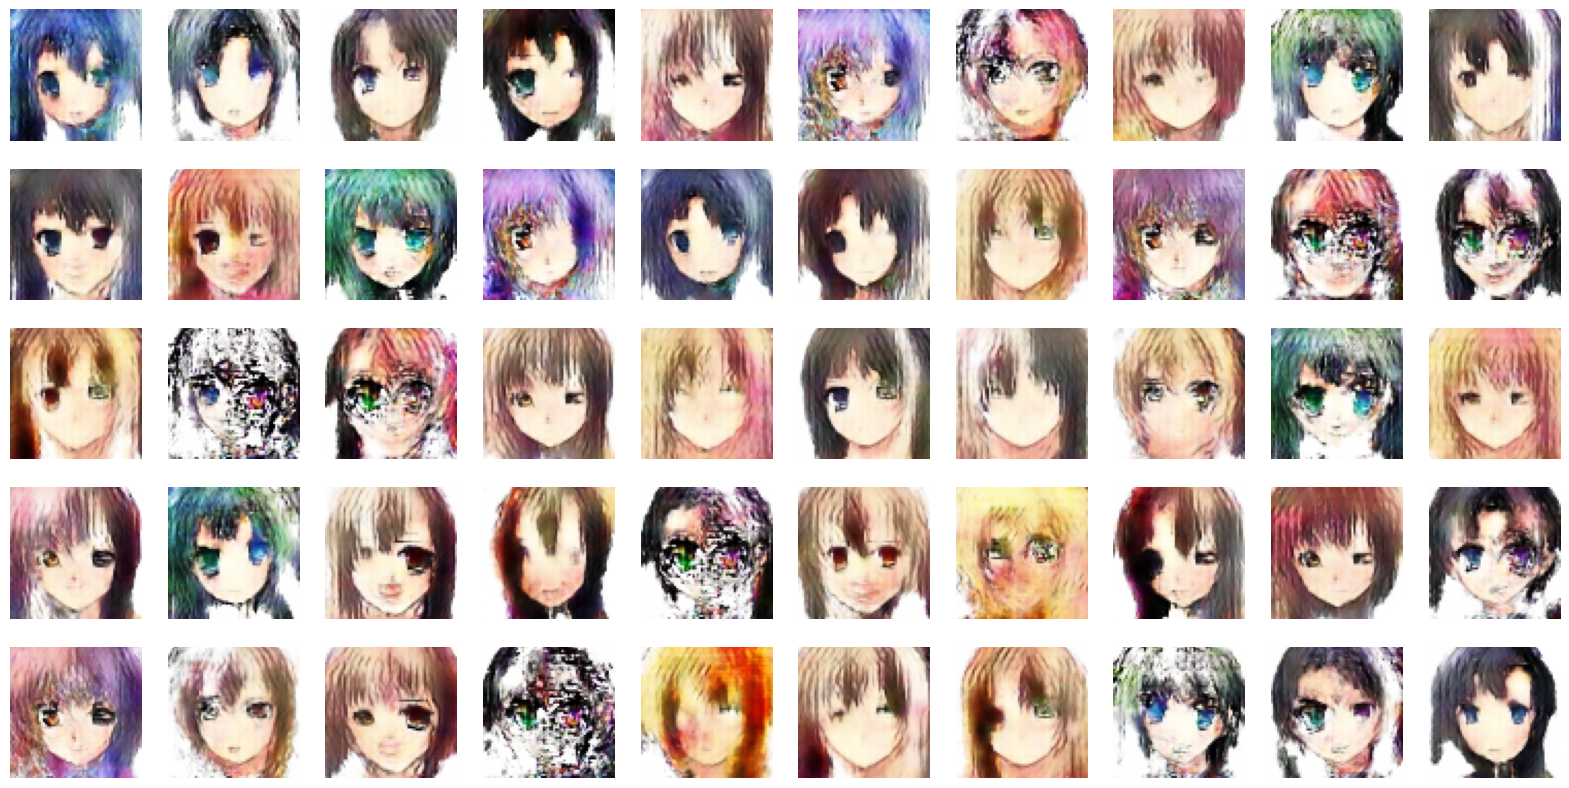

In [ ]:
r, c = 5, 10
noise = tf.random.normal(shape=(r * c, latent_dim))
gen_imgs = generator.predict(noise)
# Visualize the generated images
fig, axs = plt.subplots(r, c, figsize=(c * 2, r * 2))
cnt = 0
for i in range(r):
  for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt])
      axs[i, j].axis('off')
      cnt += 1
plt.show()

# Model save

In [ ]:
generator.save('/content/drive/MyDrive/generator.h5')
discriminator.save('/content/drive/MyDrive/discriminator.h5')